# Description SVM

## Libraries

In [1]:
!pip install wikidata

import nltk
import time
import math
import tqdm
import json
import spacy
import joblib
import requests
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from bs4 import BeautifulSoup
from itertools import product
from nltk.corpus import stopwords
from wikidata.client import Client
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Collecting the dataset

In [2]:
# Da sistemare per la consegna
from google.colab import drive, files

drive.mount('/content/gdrive', force_remount=False)

dir_path   =  "/content/gdrive/My Drive/MNLP/HW1/"
train_path = "train.csv"
dev_path   = "valid.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
train_df = pd.read_csv(dir_path + train_path, encoding='utf-8')
dev_df = pd.read_csv(dir_path + dev_path, encoding='utf-8')

## TF_IDF computation

### Methods

In [4]:
UNK_TOKEN = '<UNK>'
STOPWORDS = set(stopwords.words('english'))
REMOVED_WORDS = ['ˈ', 'also', 'since', 'many']
lemmatizer = WordNetLemmatizer()

for word in REMOVED_WORDS:
    STOPWORDS.add(word)

def tokenize(doc):
    tokens = word_tokenize(doc.lower())
    tokens = [w for w in tokens if w.isalpha() and w not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

def tf(doc):
    tf_ = {}
    words = tokenize(doc)
    cnt = Counter(words)
    normalization_factor = len(words)
    for word, occs in cnt.items():
        tf_[word] = occs / normalization_factor

    return tf_

def idf(texts):
    idf_ = {}
    N = len(texts)
    tokenized_docs = [set(tokenize(doc)) for doc in texts]
    all_words = set(word for doc in tokenized_docs for word in doc)

    for word in tqdm.tqdm(all_words):
        doc_cnt = sum(1 for doc in tokenized_docs if word in doc)
        idf_[word] = math.log((1 + N) / (1 + doc_cnt)) + 1
    return idf_

def idf_by_category(df):
    categorical_idf = {}
    grouped = df.groupby('category')['description'].apply(list)

    for cat, docs in grouped.items():
        categorical_idf[cat] = idf(docs)

    return categorical_idf

def tf_idf(tf_, idf_, word_index=None, unk_token=UNK_TOKEN):
    tfidf = {}
    unk_val = 0.0

    for word, tf_val in tf_.items():
        idf_val = idf_.get(word, 1.0)
        value = tf_val * idf_val

        if word_index is not None and word not in word_index:
            unk_val += value
        else:
            tfidf[word] = value

    if word_index is not None and unk_token in word_index:
        tfidf[unk_token] = unk_val

    return tfidf

def vectorize(tfidf_dict, word_index, unk_token=UNK_TOKEN):
    vec = np.zeros(len(word_index))
    unk_idx = word_index.get(unk_token)

    for word, value in tfidf_dict.items():
        if word in word_index:
            vec[word_index[word]] = value
        elif unk_idx is not None:
            vec[unk_idx] += value
    return vec

## Label mapping

In [5]:
labels = {
    'cultural exclusive': 0,
    'cultural agnostic': 1,
    'cultural representative': 2
}

train_df['label'] = train_df['label'].map(labels)
dev_df['label'] = dev_df['label'].map(labels)

In [6]:
train_df.head(10)

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,0
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,2
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,2
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,2
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,0
5,http://www.wikidata.org/entity/Q104414508,100 percent corner,term for city center,concept,geography,city,1
6,http://www.wikidata.org/entity/Q3008535,1889 Apia cyclone,Category 1 South Pacific cyclone in 1889,entity,history,historical event,1
7,http://www.wikidata.org/entity/Q85720601,18th Abduction,novel by James patterson,entity,books,book,1
8,http://www.wikidata.org/entity/Q105570,20 July plot,"attempt to assassinate Adolf Hitler, 1944",entity,history,historical event,0
9,http://www.wikidata.org/entity/Q434841,20th Century Studios,American film studio owned by The Walt Disney ...,entity,media,film studio,2


In [7]:
dev_df.head()

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,2
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,0
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,2
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,0
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,2


### Test TF_IDF

### Categorical TF-IDF

In [8]:
idf_cat = idf_by_category(train_df)
tfidf = []

for _, row in tqdm.tqdm(train_df.iterrows(), total=len(train_df), colour='green'):
    doc = row['description']
    cat = row['category']
    enh_tf_ = tf(doc)
    enh_idf_ = idf_cat.get(cat, {})
    enh_tfidf = tf_idf(enh_tf_, enh_idf_)
    tfidf.append(enh_tfidf)

train_df['tf_idf'] = tfidf

100%|██████████| 6251/6251 [00:03<00:00, 2066.51it/s]


## Test SVM

## Categorical TF-IDF + One-hot-encoding

In [9]:
cols_to_encode = ['type', 'subcategory']

encoder = OneHotEncoder(handle_unknown='ignore')
onehotvec_train = encoder.fit_transform(train_df[cols_to_encode]).toarray().astype(float)
onehotvec_valid = encoder.transform(dev_df[cols_to_encode]).toarray().astype(float)

In [10]:
enh_dict = train_df['tf_idf'].to_list()

vocab = sorted(set(word for doc in train_df['description'] for word in tokenize(doc)))
word_index = {word: idx for idx, word in enumerate(vocab)}

dev_tfidf = []
for _, row in tqdm.tqdm(dev_df.iterrows(), total=len(dev_df), colour='green'):
    doc = row['description']
    cat = row['category']
    enh_tf_ = tf(doc)
    enh_idf_ = idf_cat.get(cat, {})
    enh_tfidf = tf_idf(enh_tf_, enh_idf_)
    dev_tfidf.append(enh_tfidf)
dev_df['tf_idf'] = dev_tfidf

val_docs = dev_df['tf_idf'].to_list()

X = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in enh_dict])
X_val = np.array([vectorize(doc_tfidf, word_index) for doc_tfidf in val_docs])
y = np.array(train_df['label'])
y_val = np.array(dev_df['label'])

X = np.hstack([X, onehotvec_train])
X_val = np.hstack([X_val, onehotvec_valid])

100%|██████████| 300/300 [00:00<00:00, 948.16it/s]


### Class weights computation

In [11]:
weights_dict = {
    1: 0.2995, # cultural agnostic
    2: 0.2700, # cultural representative
    0: 0.4305  # cultural exclusive
}

def weights_computation(freq_dict):
    weights = {k: 1/v for k, v in freq_dict.items()}
    norm_factor = sum(weights.values())
    norm_weights = {k: v/norm_factor for k, v in weights.items()}
    return norm_weights

class_weights = weights_computation(freq_dict=weights_dict)
print(f"{class_weights}")

{1: 0.3565110774234955, 2: 0.395463213660507, 0: 0.24802570891599746}


## Test models

In [ ]:
C_vals = [5, 7, 10]
gamma = 'scale'
kernels = ['linear']

best_score = 0
best_params = {}
best_model = None

for C, kernel in product(C_vals, kernels):
    print(f"Testing: C={C}, gamma={gamma}, kernel={kernel}")

    svc = SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weights, probability=True)

    try:
        svc.fit(X, y)

        y_pred = svc.predict(X_val)
        score = accuracy_score(y_val, y_pred)

        print(f"Accuracy: {score:.4f}")
        print(f"F1 macro score: {f1_score(y_val, y_pred, average='macro'):.4f}")

        if score > best_score:
            best_score  = score
            best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
            best_model  = svc

    except Exception as e:
        print(f"ERROR! Params:\tC={C}, gamma={gamma}, kernel={kernel}: {e}")

Testing: C=5, gamma=scale, kernel=linear
Accuracy: 0.6767
F1 macro score: 0.6674
Testing: C=7, gamma=scale, kernel=linear
Accuracy: 0.6800
F1 macro score: 0.6711
Testing: C=10, gamma=scale, kernel=linear
Accuracy: 0.6767
F1 macro score: 0.6684


In [14]:
print("Best parameters found:", best_params)
y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))

Best parameters found: {'C': 7, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.52      0.70      0.60        76
           1       0.83      0.78      0.81       117
           2       0.67      0.56      0.61       107

    accuracy                           0.68       300
   macro avg       0.68      0.68      0.67       300
weighted avg       0.70      0.68      0.68       300



In [15]:
joblib.dump(best_model, dir_path + "DescriptionSVM.pkl")

['/content/gdrive/My Drive/MNLP/HW1/DescriptionSVM.pkl']

---

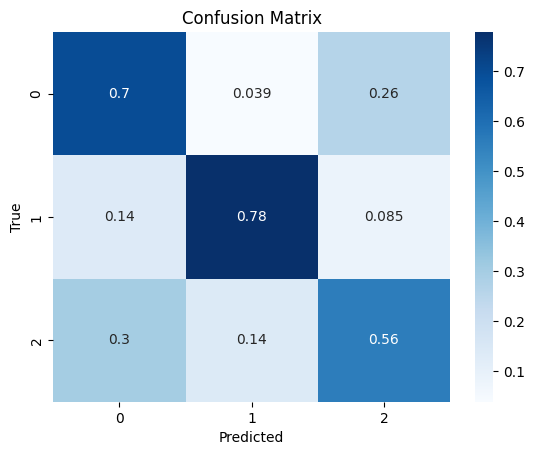

In [16]:
cm = confusion_matrix(y_val, y_pred, normalize='true')
labels = np.unique(y_val)
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [17]:
error_df = dev_df.copy()
error_df['true_label'] = y_val
error_df['predicted'] = y_pred
error_df['correct'] = error_df['true_label'] == error_df['predicted']

mistakes = error_df[~error_df['correct']]

mistakes[['name', 'description', 'true_label', 'predicted']].sample(10, random_state=42)

,name,description,true_label,predicted
252,skateboard,wheeled board used for skateboarding,1,2
245,Shepperton Studios,"film studio, special effects studios and pre- ...",0,2
225,pyramid,structure whose shape is roughly that of a pyr...,1,0
294,wolf pit,pit for trapping wolves,1,0
114,gauze,thin translucent fabric with a open weave,1,0
251,Siuuu,Football celebration gesture,2,0
214,Pinewood Toronto Studios,filming location,0,2
142,Karl Landsteiner,"Jewish-Austrian biologist, physician and Nobel...",2,0
0,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",2,0
33,Baltic song festivals,song and dance festivals in Baltic states,2,0


In [18]:
mistakes_per_label = mistakes.groupby('true_label')['predicted'].value_counts().unstack(fill_value=0)
print(mistakes_per_label)

predicted    0   1   2
true_label            
0            0   3  20
1           16   0  10
2           32  15   0


In [19]:
tokens_errors = [token for doc in mistakes['description'] for token in tokenize(doc)]
common_error_words = Counter(tokens_errors).most_common(50)
print("Most common words in misclassified samples:")
print(common_error_words)

Most common words in misclassified samples:
[('american', 5), ('group', 5), ('music', 5), ('film', 5), ('art', 4), ('dance', 4), ('traditional', 4), ('studio', 4), ('song', 3), ('party', 3), ('genre', 3), ('particular', 3), ('religious', 3), ('book', 3), ('leader', 3), ('tradition', 3), ('country', 3), ('based', 2), ('body', 2), ('literature', 2), ('type', 2), ('gesture', 2), ('acting', 2), ('festival', 2), ('state', 2), ('museum', 2), ('berlin', 2), ('political', 2), ('profession', 2), ('fabric', 2), ('small', 2), ('title', 2), ('baroque', 2), ('palace', 2), ('official', 2), ('church', 2), ('roman', 2), ('south', 2), ('asia', 2), ('people', 2), ('form', 2), ('object', 2), ('belief', 2), ('held', 2), ('worldwide', 2), ('france', 2), ('ancient', 2), ('judaism', 2), ('effect', 2), ('performance', 2)]
